## What is tested in this notebook

The goal is to see if a inheritly high dimensional distribution cannot be compressed into a smaller
dimensional space and then relearned. For example, 10-dimensional Gaussian cannot be compressed into 2d and then relearned.

Also in all the tests here I want to use infinite database, meaning during training and testing, we always generate new samples from the distribution we try to learn, rather then cycle over a fixed size
database.

In [60]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch import distributions
from math import sqrt, pi, e

import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self, nin, nh, nout):
        super(Net, self).__init__()

        self.main = nn.Sequential(
                nn.Linear(nin, nh), 
                nn.ReLU(),
                nn.Linear(nh, nh), 
                nn.ReLU(),
                nn.Linear(nh, nout), 
                )

    def forward(self, x):
        return self.main(x)

mse = nn.MSELoss()

# test 1: learning sin function. Using 'infinite' sample space.
device = "cuda"
net = Net(1, 20, 1).to(device)
optimizer = optim.Adam(net.parameters())

for epoch in range(3000):
    net.zero_grad()
    x = torch.rand((128,1)).to(device)
    x = 2 * torch.pi * x
    y = torch.sin(x)
    z = net(x)
    loss = mse(z,y)
    loss.backward()
    optimizer.step()
    if epoch % 250 == 0:
        print("loss = ", loss.item())


loss =  0.5611025094985962
loss =  0.10756388306617737
loss =  0.08233628422021866
loss =  0.0250440314412117
loss =  0.014137941412627697
loss =  0.0036776356864720583
loss =  0.0019450467079877853
loss =  0.0006038003484718502
loss =  0.00028223442495800555
loss =  0.0002624916669446975
loss =  0.00028177746571600437
loss =  0.0002663311897777021


In [61]:
x = torch.linspace(0, torch.pi * 2, 1000).to(device)
x = x.reshape((1000,1))

y = torch.sin(x)
z = net(x)
mse(z, y)



tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)

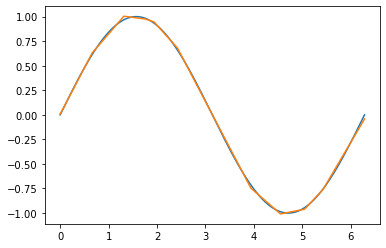

In [62]:
x = x.flatten().detach().cpu().numpy()
y = y.flatten().detach().cpu().numpy()
z = z.flatten().detach().cpu().numpy()


plt.plot(x, y)

plt.plot(x, z)


In [63]:
# Test 2: a 'shrinking' autoendoder

class AE(nn.Module):
    def __init__(self, nin, nh, nz):
        super(AE, self).__init__()

        self.encode = nn.Sequential(
                nn.Linear(nin, nh), 
                nn.ReLU(),
                nn.Linear(nh, nh), 
                nn.ReLU(),
                nn.Linear(nh, nz), 
                )

        self.decode = nn.Sequential(
                nn.Linear(nz, nh*2), 
                nn.ReLU(),
                nn.Linear(nh*2, nh*2), 
                nn.ReLU(),
                nn.Linear(nh*2, nin), 
                #nn.Tanhshrink(),
                #nn.Tanh(),
                #nn.ReLU(),
                )

        self.fc1 = nn.Linear(nin, 1)
        self.fc2 = nn.Linear(nin, 1)

    def forward(self, x):
        h = self.encode(x)
        y = self.decode(h)
        #x1 = self.fc1(h)
        #x2 = self.fc2(h)
        #y = torch.cat((x1,x2), dim=1)
        return y

# Expand 2d gaussian to 4d, then try to regenerate the original
model = AE(2, 1000, 4).to(device)
#model = AE(2, 1000, 1).to(device)
optimizer = optim.Adam(model.parameters())

for epoch in range(3000):
    model.zero_grad()
    x = torch.randn((128,2)).to(device)
    x = x 
    y = model(x)
    loss = mse(y,x)
    loss.backward()
    optimizer.step()
    if epoch % 350 == 0:
        print("loss = ", loss.item())


loss =  1.0845128297805786
loss =  5.297555617289618e-06
loss =  0.0007983815157786012
loss =  0.0005068866885267198
loss =  0.0010753042297437787
loss =  3.435386315686628e-05
loss =  0.0006552455015480518
loss =  0.0001348452060483396
loss =  6.018031854182482e-05


tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)


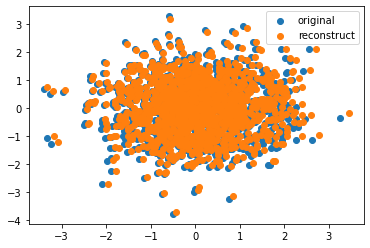

In [64]:
xs = torch.randn((1280,2)).to(device)
zs = model(xs)
print( mse(xs, zs) )
xs = xs.detach().cpu().numpy()
zs = zs.detach().cpu().numpy()

x = xs[:,0]
y = xs[:,1]
plt.scatter(x,y)

x = zs[:,0]
y = zs[:,1]
plt.scatter(x,y)
plt.legend(['original', 'reconstruct'])



In [65]:
# lets try to see if we can shrink the 2d gaussian to 1d and relearn....
model = AE(2, 1000, 1).to(device)
optimizer = optim.Adam(model.parameters())

for epoch in range(3000):
    model.zero_grad()
    x = torch.randn((128,2)).to(device)
    x = x 
    y = model(x)
    loss = mse(y,x)
    loss.backward()
    optimizer.step()
    if epoch % 350 == 0:
        print("loss = ", loss.item())


loss =  0.9573439955711365
loss =  0.24755650758743286
loss =  0.33402252197265625
loss =  0.24139946699142456
loss =  0.21415306627750397
loss =  0.2254752367734909
loss =  0.16299670934677124
loss =  0.19607460498809814
loss =  0.1443137377500534


tensor(0.1486, device='cuda:0', grad_fn=<MseLossBackward0>)


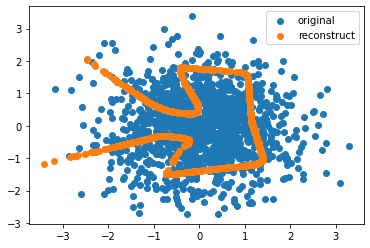

In [66]:
xs = torch.randn((1280,2)).to(device)
zs = model(xs)
print( mse(xs, zs) )
xs = xs.detach().cpu().numpy()
zs = zs.detach().cpu().numpy()

x = xs[:,0]
y = xs[:,1]
plt.scatter(x,y)

x = zs[:,0]
y = zs[:,1]
plt.scatter(x,y)
plt.legend(['original', 'reconstruct'])


## Conclusions?

Maybe this is trivial but it seems that the high dimensional distribution cannot be shrinked and then
rebuilt. The reconstruction is effectively a one dimensional curve, presumingly the more it trains 
the more it may become more winding in an attempt to fill in the space.

In [67]:
eps = 1e-6
x = torch.linspace(eps - torch.pi /2, - eps + torch.pi/2, 5000)
y = torch.tan(x)
print(y[0], y[1], y[-2], y[-1])

tensor(-971654.6875) tensor(-1588.5608) tensor(1588.5608) tensor(971654.6875)


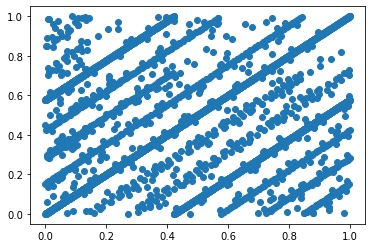

In [68]:
u = y % torch.pi
u = u % 1
v = y % torch.e
v = v % 1

def fnorm(x, mu=0, s=1):
    x = -0.5 * ((x - mu) / s)**2
    x = x.exp()
    x = x / s
    x = x / sqrt(2 * pi)
    return x

def invfnorm(x, mu=0, s=1):
    """
    inverse of standard normal distribution.
    """
    x = s * sqrt(2 * pi) * x
    x = x.log()
    x = -2 * x
    x = x.sqrt()
    x = x * s
    x = x + mu
    return x
    
#u = fnorm(u)
#v = fnorm(v)
u = u.detach().cpu().numpy()
v = v.detach().cpu().numpy()
plt.scatter(u,v)


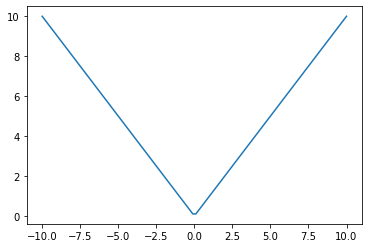

In [69]:
x = torch.linspace(-10, 10, 100)
y = invfnorm(fnorm(x))

x = x.numpy()
y = y.numpy()

plt.plot(x,y)

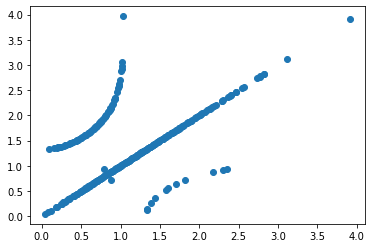

In [70]:
eps = 1e-6
x = torch.linspace(eps - torch.pi /2, - eps + torch.pi/2, 5000)
y = torch.tan(x)
u = y % torch.pi
u = 10*u % 4
v = y % torch.e
v = 10*v % 4

u = invfnorm(u)
v = invfnorm(v)

u = u.detach().cpu().numpy()
v = v.detach().cpu().numpy()
plt.scatter(u,v)